In [1]:
# =========================
# 0) Imports & paths
# =========================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)

YIELD_PATH = "../raw_data/barley_yield_from_1982.csv"
CLIMATE_PATH = "../raw_data/climate_data_from_1982.parquet"

In [2]:
# =========================
# 1) Load correctly (IMPORTANT)
# =========================
# Your CSV is ; separated -> sep=";"
df_yield = pd.read_csv(YIELD_PATH, sep=";")

df_climate = pd.read_parquet(CLIMATE_PATH)

print("df_yield:", df_yield.shape)
print("df_climate:", df_climate.shape)

display(df_yield.head())
display(df_climate.head())

df_yield: (3583, 6)
df_climate: (13540116, 7)


,Unnamed: 0,department,year,yield,area,production
0,82,Ain,1982,3.95008,16065.0,63458.0
1,83,Ain,1983,NaN,14500.0,38400.0
2,84,Ain,1984,4.82258,15500.0,74750.0
3,85,Ain,1985,4.19677,15500.0,65050.0
4,86,Ain,1986,3.59845,12900.0,46420.0


,scenario,nom_dep,code_dep,time,year,metric,value
29950,historical,Ain,01,1982-01-01 12:00:00,1982,near_surface_air_temperature,276.292267
29951,historical,Ain,01,1982-01-02 12:00:00,1982,near_surface_air_temperature,275.092407
29952,historical,Ain,01,1982-01-03 12:00:00,1982,near_surface_air_temperature,276.418518
29953,historical,Ain,01,1982-01-04 12:00:00,1982,near_surface_air_temperature,278.893372
29954,historical,Ain,01,1982-01-05 12:00:00,1982,near_surface_air_temperature,278.887207


In [3]:
# =========================
# 2) Utility functions (EDA helpers)
# =========================
def clean_cols(df: pd.DataFrame) -> pd.DataFrame:
    """Clean column names."""
    df = df.copy()
    df.columns = (
        df.columns.astype(str)
        .str.strip()
        .str.lower()
        .str.replace(r"\s+", "_", regex=True)
        .str.replace(r"[^a-z0-9_]", "", regex=True)
    )
    return df


def overview(df: pd.DataFrame, name: str):
    """Print an overview of the DataFrame."""
    print(f"\n{'=' * 90}\n{name}\n{'=' * 90}")
    print("shape:", df.shape)
    display(df.head(5))

    print("\n--- dtypes ---")
    # FIX: make dtypes sortable by converting to string
    dtypes_sorted = df.dtypes.astype(str).sort_values()
    display(dtypes_sorted.to_frame("dtype"))

    print("\n--- missing (% top 25) ---")
    miss = (df.isna().mean().sort_values(ascending=False) * 100).head(25)
    display(miss.to_frame("% missing"))

    print("\n--- duplicates ---")
    print("duplicate rows:", df.duplicated().sum())


def numeric_stats(df: pd.DataFrame, name: str):
    """Calculate and display statistics for numeric columns."""
    num = df.select_dtypes(include=[np.number])
    print(f"\n{name} - numeric columns:", list(num.columns))
    if num.shape[1] == 0:
        return
    display(num.describe().T)


def categorical_stats(df: pd.DataFrame, name: str, topk=15, max_cols=8):
    """Calculate and display statistics for categorical columns."""
    cat_cols = df.select_dtypes(
        include=["object", "string", "category", "bool"]
    ).columns.tolist()
    print(f"\n{name} - categorical columns:", cat_cols)
    if not cat_cols:
        return
    card = df[cat_cols].nunique(dropna=True).sort_values(ascending=False)
    display(card.to_frame("n_unique"))

    for c in card.head(min(max_cols, len(card))).index:
        print(f"\nTop values for '{c}'")
        display(df[c].value_counts(dropna=False).head(topk).to_frame("count"))

In [4]:
# =========================
# 3) Clean column names + basic overview
# =========================
df_yield = clean_cols(df_yield)
df_climate = clean_cols(df_climate)

overview(df_yield, "df_yield")
overview(df_climate, "df_climate")

numeric_stats(df_yield, "df_yield")
categorical_stats(df_yield, "df_yield")

# df_climate is huge: we do careful summaries below
categorical_stats(df_climate, "df_climate", topk=10, max_cols=6)


df_yield
shape: (3583, 6)


,unnamed_0,department,year,yield,area,production
0,82,Ain,1982,3.95008,16065.0,63458.0
1,83,Ain,1983,NaN,14500.0,38400.0
2,84,Ain,1984,4.82258,15500.0,74750.0
3,85,Ain,1985,4.19677,15500.0,65050.0
4,86,Ain,1986,3.59845,12900.0,46420.0



--- dtypes ---


,dtype
yield,float64
area,float64
production,float64
unnamed_0,int64
year,int64
department,str



--- missing (% top 25) ---


,% missing
yield,6.893665
production,3.404968
area,3.209601
unnamed_0,0.000000
department,0.000000
year,0.000000



--- duplicates ---
duplicate rows: 0

df_climate
shape: (13540116, 7)


,scenario,nom_dep,code_dep,time,year,metric,value
29950,historical,Ain,01,1982-01-01 12:00:00,1982,near_surface_air_temperature,276.292267
29951,historical,Ain,01,1982-01-02 12:00:00,1982,near_surface_air_temperature,275.092407
29952,historical,Ain,01,1982-01-03 12:00:00,1982,near_surface_air_temperature,276.418518
29953,historical,Ain,01,1982-01-04 12:00:00,1982,near_surface_air_temperature,278.893372
29954,historical,Ain,01,1982-01-05 12:00:00,1982,near_surface_air_temperature,278.887207



--- dtypes ---


,dtype
time,datetime64[ns]
value,float32
year,int32
scenario,str
nom_dep,str
code_dep,str
metric,str



--- missing (% top 25) ---


,% missing
scenario,0.0
nom_dep,0.0
code_dep,0.0
time,0.0
year,0.0
metric,0.0
value,0.0



--- duplicates ---
duplicate rows: 0

df_yield - numeric columns: ['unnamed_0', 'year', 'yield', 'area', 'production']


,count,mean,std,min,25%,50%,75%,max
unnamed_0,3583.0,5805.017862,3330.517723,82.00000,2945.50000,5809.00000,8672.500000,11536.0
year,3583.0,1999.971532,10.664744,1982.00000,1991.00000,2000.00000,2009.000000,2018.0
yield,3336.0,5.212239,1.369354,0.81356,4.24253,5.26123,6.225615,8.4
area,3468.0,18767.079585,20266.789390,0.00000,3766.50000,11810.50000,27495.500000,119310.0
production,3461.0,110239.297180,133060.332166,0.00000,17240.00000,56744.90000,153285.200000,919249.6



df_yield - categorical columns: ['department']


,n_unique
department,97



Top values for 'department'


,count
department,
Ain,37
Aisne,37
Allier,37
Alpes_de_Haute_Provence,37
Alpes_Maritimes,37
Ardeche,37
Ardennes,37
Ariege,37
Aube,37



df_climate - categorical columns: ['scenario', 'nom_dep', 'code_dep', 'metric']


,n_unique
nom_dep,89
code_dep,89
scenario,4
metric,3



Top values for 'nom_dep'


,count
nom_dep,
Ain,154500
Aisne,154500
Allier,154500
Alpes_Maritimes,154500
Alpes_de_Haute_Provence,154500
Ardeche,154500
Ardennes,154500
Ariege,154500
Aube,154500



Top values for 'code_dep'


,count
code_dep,
01,154500
02,154500
03,154500
06,154500
04,154500
07,154500
08,154500
09,154500
10,154500



Top values for 'scenario'


,count
scenario,
ssp1_2_6,3510783
ssp5_8_5,3510783
ssp2_4_5,3300399
historical,3218151



Top values for 'metric'


,count
metric,
near_surface_air_temperature,4583500
daily_maximum_near_surface_air_temperature,4478308
precipitation,4478308


Index(['unnamed_0', 'department', 'year', 'yield', 'area', 'production'], dtype='str')
Year range: 1982 -> 2018


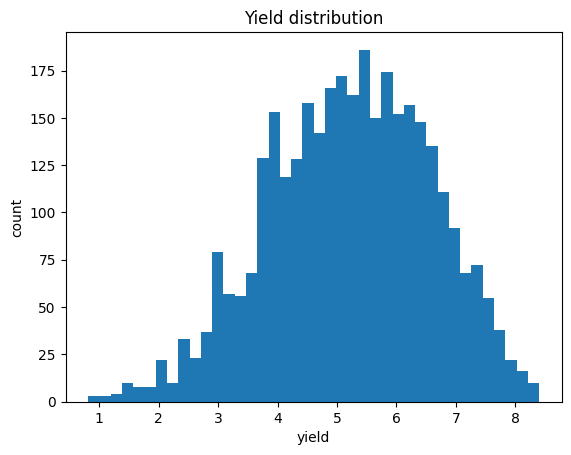

,count,mean,median
department,,,
Somme,29,7.295618,7.397900
Pas_de_Calais,28,7.243320,7.390420
Nord,34,7.188541,7.353460
Seine_Maritime,31,7.136843,7.121090
Oise,31,7.052062,7.135880
Eure,34,7.029995,7.032000
Aisne,36,6.989706,7.071750
Eure_et_Loir,33,6.985760,7.026550
Marne,36,6.974308,6.997650


In [5]:
# =========================
# 4) df_yield checks
# =========================
# Common expected columns given your screenshot: department, year, yield, area,
# production
print(df_yield.columns)

# Convert numeric columns safely if needed
for c in ["year", "yield", "area", "production"]:
    if c in df_yield.columns:
        df_yield[c] = pd.to_numeric(df_yield[c], errors="coerce")

# Basic sanity checks
if "year" in df_yield.columns:
    print("Year range:", df_yield["year"].min(), "->", df_yield["year"].max())

# Quick plots
if "yield" in df_yield.columns:
    plt.figure()
    plt.hist(df_yield["yield"].dropna(), bins=40)
    plt.title("Yield distribution")
    plt.xlabel("yield")
    plt.ylabel("count")
    plt.show()

# If you have a department column, show top departments by avg yield
dep_col = None
for c in ["department", "nom_dep", "dep", "departement"]:
    if c in df_yield.columns:
        dep_col = c
        break

if dep_col and "yield" in df_yield.columns:
    dep_summary = (
        df_yield.groupby(dep_col)["yield"]
        .agg(count="count", mean="mean", median="median")
        .sort_values("mean", ascending=False)
    )
    display(dep_summary.head(20))

In [6]:
# =========================
# 5) df_climate structure checks
# =========================
print(df_climate.columns)

# Parse time if needed
if "time" in df_climate.columns and not np.issubdtype(
    df_climate["time"].dtype, np.datetime64
):
    df_climate["time"] = pd.to_datetime(df_climate["time"], errors="coerce")

# Key distributions (fast-ish even on large data)
for c in ["scenario", "year", "metric"]:
    if c in df_climate.columns:
        print(f"\nValue counts for {c} (top 20):")
        display(df_climate[c].value_counts(dropna=False).head(20).to_frame("count"))

# Date range
if "time" in df_climate.columns:
    print("\nTime range:", df_climate["time"].min(), "->", df_climate["time"].max())

Index(['scenario', 'nom_dep', 'code_dep', 'time', 'year', 'metric', 'value'], dtype='str')

Value counts for scenario (top 20):


,count
scenario,
ssp1_2_6,3510783
ssp5_8_5,3510783
ssp2_4_5,3300399
historical,3218151



Value counts for year (top 20):


,count
year,
2016,287310
2020,287310
2024,287310
2028,287310
2032,287310
2036,287310
2040,287310
2044,287310
2048,287310



Value counts for metric (top 20):


,count
metric,
near_surface_air_temperature,4583500
daily_maximum_near_surface_air_temperature,4478308
precipitation,4478308



Time range: 1982-01-01 12:00:00 -> 2050-12-31 12:00:00


,% missing
scenario,0.0
nom_dep,0.0
code_dep,0.0
time,0.0
year,0.0
metric,0.0
value,0.0



df_climate - numeric columns: ['year', 'value']


,count,mean,std,min,25%,50%,75%,max
year,13540116.0,2024.299942,17.873647,1.982000e+03,2015.000000,2027.000000,2039.000000,2050.000000
value,13540116.0,191.579376,134.845993,-2.681981e-23,0.000096,280.391602,288.670753,319.311035


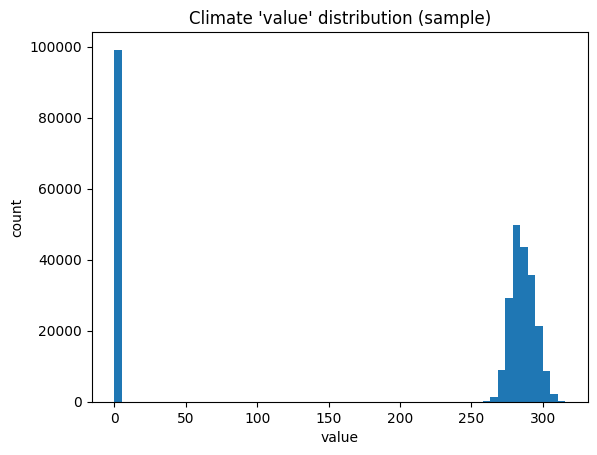

In [7]:
# =========================
# 6) Missingness & numeric stats
# =========================
# Full missingness (still ok)
miss_cl = df_climate.isna().mean().sort_values(ascending=False) * 100
display(miss_cl.head(20).to_frame("% missing"))

# Numeric describe on full data (usually ok)
numeric_stats(df_climate, "df_climate")

# For plots: sample (so it's responsive)
SAMPLE_N = 300_000  # adjust if too heavy/too light
df_climate_s = df_climate.sample(n=min(SAMPLE_N, len(df_climate)), random_state=42)

plt.figure()
plt.hist(df_climate_s["value"].dropna(), bins=60)
plt.title("Climate 'value' distribution (sample)")
plt.xlabel("value")
plt.ylabel("count")
plt.show()

In [8]:
# =========================
# 7) Yearly aggregation (key step)
# =========================
group_cols = [
    c
    for c in ["scenario", "code_dep", "nom_dep", "year", "metric"]
    if c in df_climate.columns
]
print("Grouping on:", group_cols)

climate_yearly = df_climate.groupby(group_cols, as_index=False)["value"].agg(
    n="count",
    mean="mean",
    std="std",
    min="min",
    p05=lambda x: x.quantile(0.05),
    p50=lambda x: x.quantile(0.50),
    p95=lambda x: x.quantile(0.95),
    max="max",
)

print("climate_yearly:", climate_yearly.shape)
display(climate_yearly.head())

Grouping on: ['scenario', 'code_dep', 'nom_dep', 'year', 'metric']
climate_yearly: (37071, 13)


,scenario,code_dep,nom_dep,year,metric,n,mean,std,min,p05,p50,p95,max
0,historical,01,Ain,1982,daily_maximum_near_surface_air_temperature,365,287.482666,8.055373,2.675464e+02,2.761700e+02,286.646729,300.051819,305.540894
1,historical,01,Ain,1982,near_surface_air_temperature,365,282.779236,7.090539,2.653246e+02,2.721939e+02,282.311493,293.877838,298.507812
2,historical,01,Ain,1982,precipitation,365,0.000075,0.000120,9.783581e-12,1.573405e-10,0.000014,0.000305,0.000870
3,historical,01,Ain,1983,daily_maximum_near_surface_air_temperature,365,286.233795,8.096182,2.671033e+02,2.739861e+02,287.119324,298.795410,302.047577
4,historical,01,Ain,1983,near_surface_air_temperature,365,281.723999,7.357677,2.628903e+02,2.698642e+02,282.309265,292.432434,295.522583


Chosen metric: near_surface_air_temperature


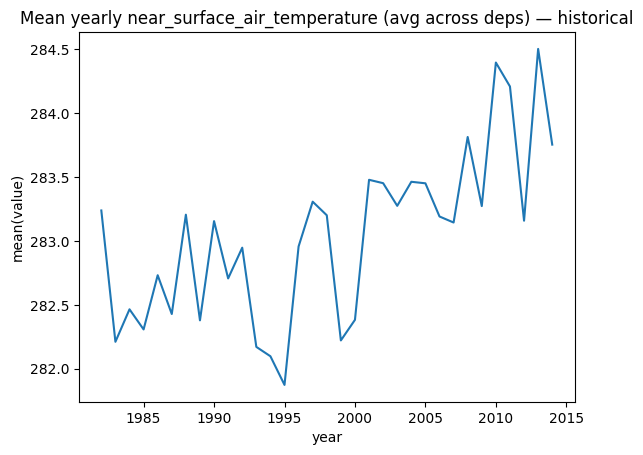

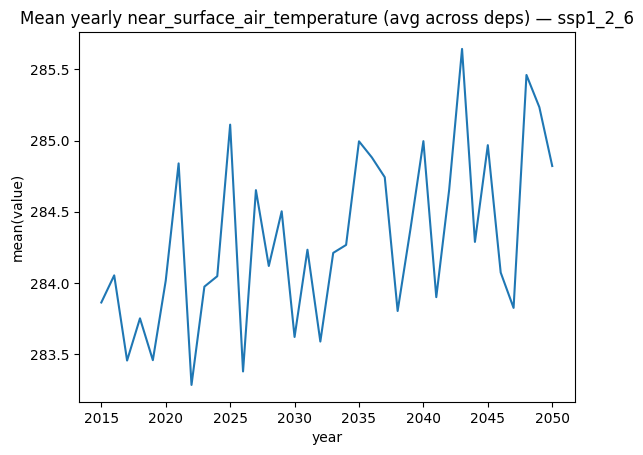

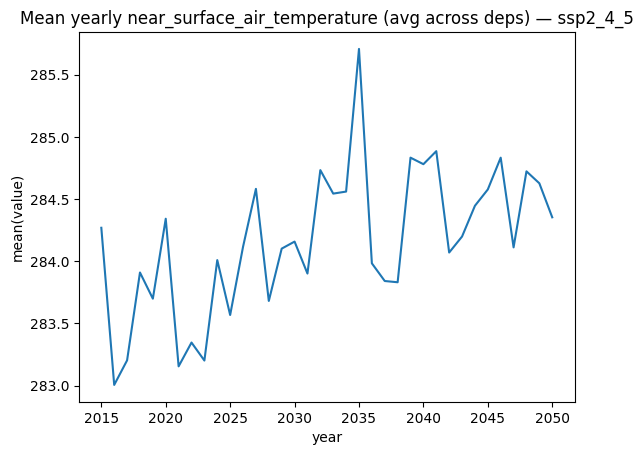

In [9]:
# =========================
# 8) Plot: yearly mean by scenario for a chosen metric
# =========================
# Pick one metric automatically (most frequent)
metric_choice = (
    df_climate["metric"].value_counts().index[0]
    if "metric" in df_climate.columns
    else None
)
print("Chosen metric:", metric_choice)

if metric_choice:
    tmp = climate_yearly[climate_yearly["metric"] == metric_choice].copy()

    # choose up to 3 scenarios to plot
    if "scenario" in tmp.columns:
        scenarios = tmp["scenario"].dropna().unique()[:3]
    else:
        scenarios = [None]

    for sc in scenarios:
        plot_df = tmp if sc is None else tmp[tmp["scenario"] == sc]

        # aggregate across departments to get a national-ish curve
        national = plot_df.groupby("year", as_index=False)["mean"].mean()

        plt.figure()
        plt.plot(national["year"], national["mean"])
        plt.title(
            f"Mean yearly {metric_choice} (avg across deps)"
            + ("" if sc is None else f" — {sc}")
        )
        plt.xlabel("year")
        plt.ylabel("mean(value)")
        plt.show()